"Geo Data Science with Python" 
### Notebook Lesson 9

# Using Machine Learning for Geo Data Analyses

---

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy.matlib



# TOS Data & SVD

First we load the dataset:

In [2]:

data = Dataset('./tos_O1_2001-2002.nc')
lat = data.variables['lat'][:].data
lon = data.variables['lon'][:].data
time = data.variables['time'][:].data
tos = data.variables['tos'][:].data
tos = tos -  273.15; # convert unit to Celcius
maskOc = tos>=1e20
maskOc_flat = maskOc[0,:,:].flatten()
tos[tos>=1e20] = 0   # set missing values to 0
data.close()

<ipython-input-2-92ab40e9f423>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = data.variables['lat'][:].data
<ipython-input-2-92ab40e9f423>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = data.variables['lon'][:].data
<ipython-input-2-92ab40e9f423>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silen

In [3]:
# generate meshgrid and ocean-only coordinate arrays
lat_grid = np.matlib.repmat(lon,len(lat),1)
lat_flat = lat_grid.flatten()
lat_ocOnly = lat_flat[maskOc_flat]

lon_grid = np.transpose(np.matlib.repmat(lat,len(lon),1))
lon_flat = lon_grid.flatten()
lon_ocOnly = lon_flat[maskOc_flat]

i_lonCut = int(max(np.argwhere(lon_ocOnly == -0.5))+1) # index to separate northern from southern hemisphere

In [4]:
tos.shape

(24, 170, 180)

Now we want to use SVD/PCA for the spatio-temporal TOS dataset, hence, we want to include all 24 maps measured over 2 years and analyze dominant spatial and temporal patterns in the data. For that we have to reshape our `tos` 3D-array into a `X` 2D-array that contains each map reshaped into a vector on one dimension, and time on the other dimension.

In [5]:
lenLon = len(lon)
lenLat = len(lat)
X = tos.reshape((24,lenLon*lenLat))
X = np.transpose(X)
X.shape


(30600, 24)

We can test if our reshaping works as planned, by retrieving the first row and reshaping it back into a global map and plotting it.

In [6]:
tos1 = X[:,0].reshape((lenLat,lenLon))
tos1.shape

(170, 180)

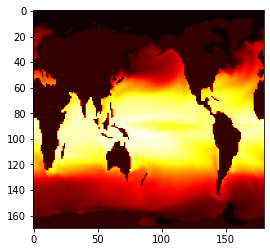

In [7]:
img = plt.imshow(np.flipud(tos1),cmap = 'hot')

The fact, that we see the continents (our no-data pixel), means our reshaping works as planned.

In the next step we want to perform a SVD/PCA with the reshaped matrix `X`, in a way to extract spatial patterns in the data.

In [8]:
u,s,vT = np.linalg.svd(X,full_matrices=0)

In [9]:
u.shape

(30600, 24)

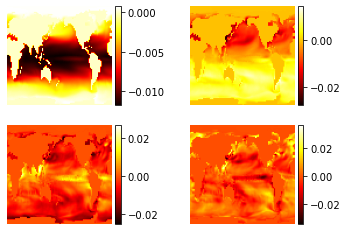

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)  # reshapes 2d axes array into a 1d array (for easier indexing)
for j in range(4):
    U = np.flipud(np.reshape(u[:,j],(lenLat,lenLon)))
    U2 = U[::2,::2]  # get only every second pixel, for smaller image size
    im = axs[j].imshow(U2,cmap='hot')
    axs[j].axis('off')
    # following lines add colorbar to each subplot
    divider = make_axes_locatable(axs[j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical');


In [11]:
vT.shape

(24, 24)

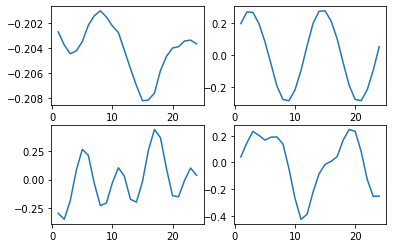

In [12]:
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for j in range(4):
    V = vT[j,:]
    im = axs[j].plot(range(1,len(V)+1),V)


For comparison, the time series of the global mean tos looks like this:

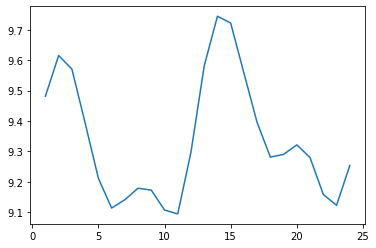

In [13]:
fig = plt.subplots(1)
im = plt.plot(range(1,25),np.mean(X,0))

The singular values contain energy of the signal components. From the following plot, we can see that the first 5 components explain almost 95% of the `tos` signal.

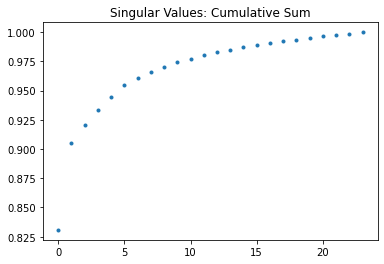

In [14]:
plt.figure()
plt.plot(np.cumsum(s)/np.sum(s),'.')
plt.title('Singular Values: Cumulative Sum')
plt.show()

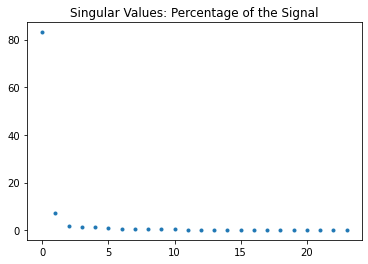

In [15]:
plt.figure()
plt.plot(s/np.sum(s)*100,'.')
plt.title('Singular Values: Percentage of the Signal')
plt.show()

---
# Analyzing the SVD output: reconstructing specific components

In [16]:
u,s,vT = np.linalg.svd(X,full_matrices=0)

In [17]:
nMC = 1  # major components that will be reconstructed
recon = u[:,nMC-1:nMC] @ np.diag(s[nMC-1:nMC])@vT[nMC-1:nMC,:]  # reconstruct time series X_r = U_r*sigma_r*V_r
recon.shape

(30600, 24)

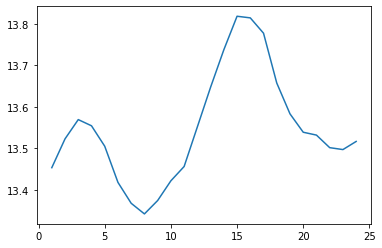

In [18]:
# Plotting the global mean of the major component (land areas removed)
fig = plt.subplots(1)
im = plt.plot(range(1,25),np.mean(recon[~maskOc_flat,:],0))

In [19]:
recon.shape

(30600, 24)

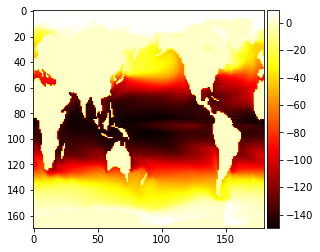

In [20]:
#  reconstructed certain feature with units: T = U*Sigma
nMC = 1
T = u[:,nMC-1:nMC] @ np.diag(s[nMC-1:nMC])
Tplot = np.flipud(np.reshape(T[:,0],(lenLat,lenLon)))

fig,axs = plt.subplots(1,1)
im = plt.imshow(Tplot,cmap='hot')
fig.colorbar(im, cax=cax, orientation='vertical');
# following lines add colorbar to each subplot
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

# Using SVD features for Cluster Analysis

### Scatter plots

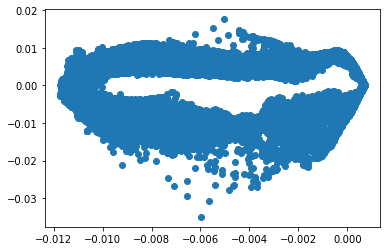

In [21]:
# 2D Scatter plot main features against each other
nMCa = 1
nMCb = 2
u_Oc = u[~maskOc_flat,:]
plt.scatter(u_Oc[:,nMCa-1:nMCa] , u_Oc[:,nMCb-1:nMCb] )

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


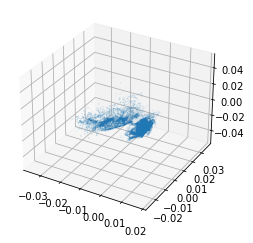

In [22]:
# 3D Scatter plot main features against each other
nMCa = 2
nMCb = 3
nMCc = 4

u_Oc = u[~maskOc_flat,:]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.scatter(u_Oc[:,nMCa-1:nMCa] , u_Oc[:,nMCb-1:nMCb] , u_Oc[:,nMCc-1:nMCc] )

### Cluster analysis with two components

In [74]:
nMCa = 2
nMCb = 3
Y = np.stack((u_Oc[:,nMCa-1] ,u_Oc[:,nMCb-1]),axis=-1)
Y.shape

(21090, 2)

In [79]:
# Clustering

nCluster = 4

#Kmeans
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=nCluster, random_state=0).fit(Y)  # Compute k-means clustering.
# cntr = kmeans.cluster_centers_
# cmask = kmeans.labels_

#AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=nCluster).fit(Y)
cmask = clustering.labels_

#SpectralClustering
# from sklearn.cluster import SpectralClustering
# clustering = SpectralClustering(n_clusters=2,assign_labels='discretize',random_state=0).fit(Y)
# cmask = clustering.labels_

#MeanShift
# from sklearn.cluster import MeanShift
# clustering = MeanShift(bandwidth=2).fit(X)
# cmask = clustering.labels_


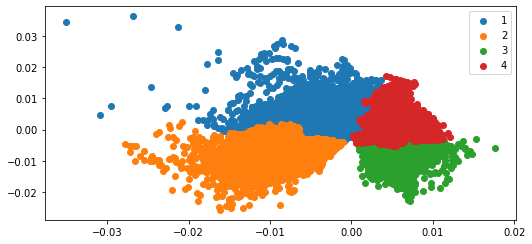

In [80]:
# Scatter plot of cluster labels

for c in range(0,nCluster):
    Y_plot = Y[cmask==c,:]
    plt.scatter(Y_plot[:,0],Y_plot[:,1],label=c+1 ) #cluster labels
    #plt.plot(cntr[c,0],cntr[c,1],'k*',ms=10) # kmeans cluster center

plt.legend()
plt.show()


In [81]:
# write resulting cluster labels on to global grid
labelGrid = np.zeros(Tplot.shape)-99
labelGrid_flat = labelGrid.flatten()
labelGrid_flat[~maskOc_flat] = cmask
labelGrid = np.reshape(labelGrid_flat, (len(lat),len(lon)))+1
labelGrid[labelGrid < -90] = np.nan

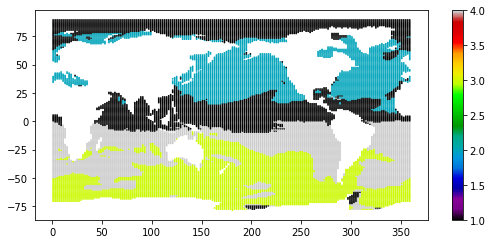

In [82]:
# plot cluster labels
plt.rcParams["figure.figsize"] = [7.50, 3.50]
fig = plt.figure()
ax = fig.add_subplot()
pm = plt.scatter(lat_grid, lon_grid, c=labelGrid, s=0.5,cmap='nipy_spectral') 
plt.colorbar(pm);
plt.show()

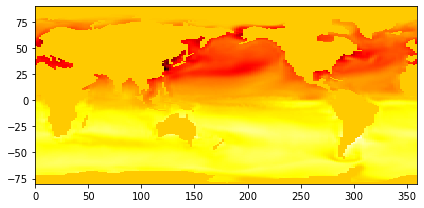

In [58]:
# plot map of certain spatial/main component (to compare)
nMC = 2
T = u[:,nMC-1:nMC] @ np.diag(s[nMC-1:nMC])
Tplot = np.reshape(T[:,0],(lenLat,lenLon))
plt.rcParams["figure.figsize"] = [6, 3]
pm = plt.pcolormesh(lat_grid, lon_grid,Tplot, shading='auto',cmap='hot')  #,cmap='nipy_spectral'
#pm = plt.scatter(lat_grid, lon_grid, c=Tplot, s=0.5)  #,cmap='nipy_spectral'
plt.show()

### Cluster analysis with four main components

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [31]:
nComponents = 8
nCluster = 6


Y=u_Oc[:,0:nComponents]

# Cluster analysis
kmeans = KMeans(n_clusters=nCluster, random_state=0).fit(Y)  # Compute k-means clustering.
cmask_km = kmeans.labels_
clustering = AgglomerativeClustering(n_clusters=nCluster).fit(Y)
cmask_agg = clustering.labels_

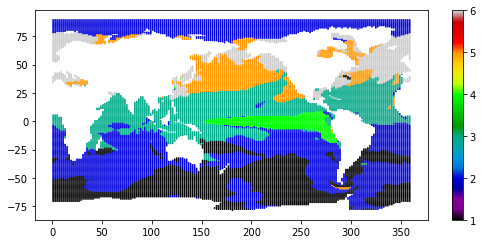

In [63]:
# plot cluster labels for kmeans clustering
labelGrid = np.zeros(Tplot.shape)-99
labelGrid_flat = labelGrid.flatten()
labelGrid_flat[~maskOc_flat] = cmask_km
labelGrid = np.reshape(labelGrid_flat, (len(lat),len(lon)))+1
labelGrid[labelGrid < -90] = np.nan
plt.rcParams["figure.figsize"] = [7.50, 3.50]
fig = plt.figure()
ax = fig.add_subplot()
pm = ax.scatter(lat_grid, lon_grid, c=labelGrid, s=0.5,cmap='nipy_spectral') 
plt.colorbar(pm);
plt.show()

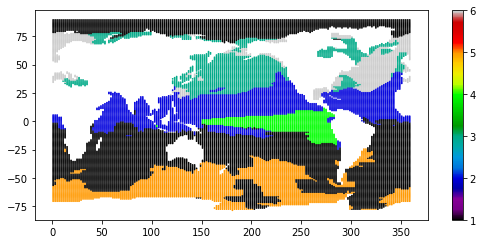

In [65]:
# plot cluster labels for AgglomerativeClustering
labelGrid2 = np.zeros(Tplot.shape)-99
labelGrid_flat2 = labelGrid.flatten()
labelGrid_flat2[~maskOc_flat] = cmask_agg
labelGrid2 = np.reshape(labelGrid_flat2, (len(lat),len(lon)))+1
labelGrid2[labelGrid2 < -90] = np.nan
plt.rcParams["figure.figsize"] = [7.50, 3.50]
fig = plt.figure()
ax = fig.add_subplot()
pm = ax.scatter(lat_grid, lon_grid, c=labelGrid2, s=0.5,cmap='nipy_spectral') 
plt.colorbar(pm);
plt.show()